In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
#from xgboost.sklearn import XGBClassifier
from xgboost import XGBClassifier
# from sklearn import cross_validation, metrics
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgboost import plot_importance
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [16]:
# Import the train set and test set
train_data2 = pd.read_csv("trainset.csv", delimiter=",")
test_data2 = pd.read_csv("testset.csv", delimiter=",")

train = pd.read_csv("normalized_train_dataset.csv", delimiter=",")
test = pd.read_csv("normalized_test_dataset.csv", delimiter=",")

# train = train.dropna()
# test = test.dropna()

In [17]:
train.shape, test.shape

((9567, 35), (3190, 34))

In [18]:
target = 'Product'
IDcol = 'ID'

In [19]:
train['Product'].value_counts()

0    5378
3    1660
2    1629
1     900
Name: Product, dtype: int64

In [20]:
test_results = pd.DataFrame({'ID': [0]})
test_results = test_results.join(pd.DataFrame({'predprob': [0]}))
test_results.to_csv('test_results.csv', index = False, encoding='utf-8')
test_results

,ID,predprob
0,0,0


In [28]:
test_results = pd.read_csv('test_results.csv')
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=10, early_stopping_rounds=50):
    
    # fit model on training data
    model = alg
    
    X_train, X_test, y_train, y_test = train_test_split(dtrain[predictors], dtrain[target], test_size=0.33, random_state=7)
    eval_set = [(X_test, y_test)]
    model.fit(X_train,
              y_train,
              early_stopping_rounds=early_stopping_rounds,
              eval_metric="merror",
              eval_set=eval_set,
              verbose=False)
    
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
#         xgtest = xgb.DMatrix(dtest[predictors].values)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='merror',
#                           early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])
    
#     #Fit the algorithm on the data
#     alg.fit(dtrain[predictors], dtrain['Product'],eval_metric='auc')
        
#     #Predict training set:
#     dtrain_predictions = alg.predict(dtrain[predictors])
#     dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
#     #Print model report:
#     print("\nModel Report")
#     print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Product'].values, dtrain_predictions))
#     #print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Product'], dtrain_predprob))
    
# #     Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    results = test_results.merge(dtest[['ID','predprob']], on='ID')
    #print(dtest[['ID','predprob']])
#     #print('AUC Score (Test): %f' % metrics.roc_auc_score(results['Product'], results['predprob']))
        
    #feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

    plot_importance(model)
    plt.show()

# Step 1- Find the number of estimators for a high learning rate

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 61.65%


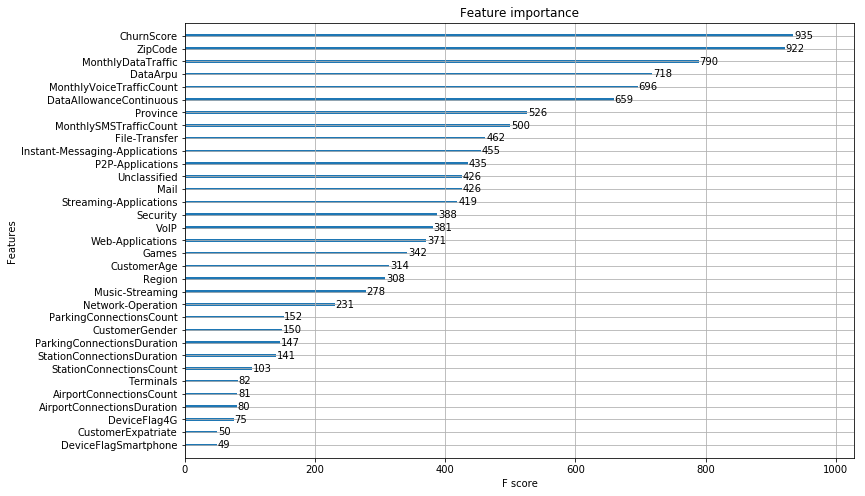

In [29]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        num_class=4,
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train, test, predictors)

In [30]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='f1_micro',n_jobs=4,iid=False, cv=5,verbose=1)
gsearch1.fit(train[predictors],train[target])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, num_class=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

In [31]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.61503, std: 0.00694, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.61513, std: 0.00606, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.61451, std: 0.00435, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.61148, std: 0.00726, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.61095, std: 0.00540, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.61085, std: 0.00472, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.60834, std: 0.00854, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.61054, std: 0.00341, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.61095, std: 0.00547, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.60928, std: 0.00580, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.60876, std: 0.00322, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.60918, std: 0.00698, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 3

In [32]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2 = {
    'max_depth':[2,3,4],
    'min_child_weight':[2,3,4]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='f1_micro',n_jobs=4,iid=False, cv=5, verbose=1)
gsearch2.fit(train[predictors],train[target])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, num_class=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': [2, 3, 4], 'min_child_weight': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

In [33]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.61315, std: 0.00444, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.61336, std: 0.00375, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.61221, std: 0.00492, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.61472, std: 0.00407, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.61513, std: 0.00606, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.61346, std: 0.00561, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.61555, std: 0.00575, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.61618, std: 0.00507, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.61492, std: 0.00637, params: {'max_depth': 4, 'min_child_weight': 4}],
 {'max_depth': 4, 'min_child_weight': 3},
 0.6161799640339976)

In [34]:
#Grid seach on subsample and max_features#Grid se 
#Choose all predictors except target & IDcols
param_test2b = {
    'min_child_weight':[4,6,8,10]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
                                        min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2b, scoring='f1_micro',n_jobs=4,iid=False, cv=5, verbose=1)
gsearch2b.fit(train[predictors],train[target])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   43.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=3, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, num_class=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [4, 6, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

In [35]:
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.61492, std: 0.00637, params: {'min_child_weight': 4},
  mean: 0.61419, std: 0.00605, params: {'min_child_weight': 6},
  mean: 0.61367, std: 0.00756, params: {'min_child_weight': 8},
  mean: 0.61189, std: 0.00731, params: {'min_child_weight': 10}],
 {'min_child_weight': 4},
 0.6149240780933619)

In [36]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
                                        min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test3, scoring='f1_micro',n_jobs=4,iid=False, cv=5, verbose=1)
gsearch3.fit(train[predictors],train[target])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   51.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=4, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, num_class=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

In [37]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.61492, std: 0.00637, params: {'gamma': 0.0},
  mean: 0.61691, std: 0.00696, params: {'gamma': 0.1},
  mean: 0.61409, std: 0.00499, params: {'gamma': 0.2},
  mean: 0.61482, std: 0.00576, params: {'gamma': 0.3},
  mean: 0.61576, std: 0.00465, params: {'gamma': 0.4}],
 {'gamma': 0.1},
 0.6169113073013427)

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 61.43%


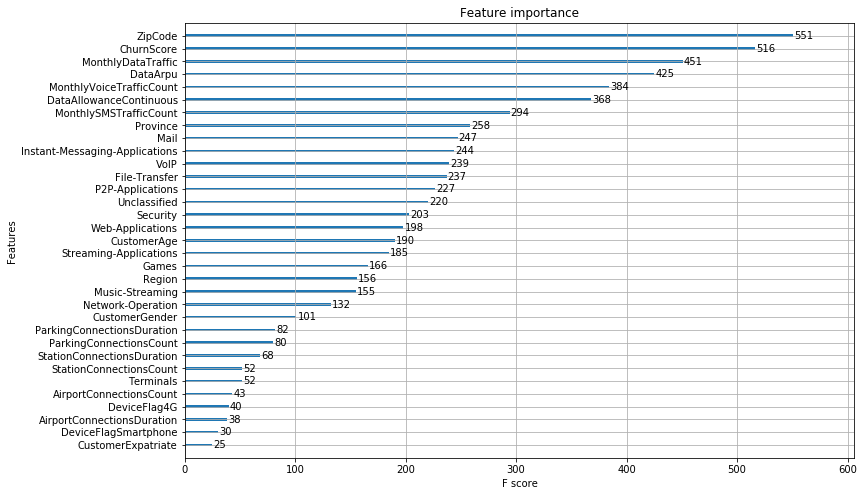

In [38]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=4,
        gamma=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob', 
        num_class=4,
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb2, train, test, predictors)

# Tune subsample and colsample_bytree

In [39]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=4, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test4, scoring='f1_micro',n_jobs=4,iid=False, cv=5, verbose=1)
gsearch4.fit(train[predictors],train[target])

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  3.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=4, missing=None,
       n_estimators=177, n_jobs=1, nthread=4, num_class=4,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

In [40]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.61054, std: 0.00689, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.61210, std: 0.00328, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.61493, std: 0.00515, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.61231, std: 0.00557, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.61315, std: 0.00626, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.61242, std: 0.00602, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.61451, std: 0.00597, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.61430, std: 0.00596, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.61294, std: 0.00871, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.61179, std: 0.00858, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.61576, std: 0.00583, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.61304, std: 0.00674, params: {'colsample_bytree': 0.8, 'subsample'

In [41]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test5 = {
    'subsample':[i/100.0 for i in range(75,90,5)],
    'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=4, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test5, scoring='f1_micro',n_jobs=4,iid=False, cv=5, verbose=1)
gsearch5.fit(train[predictors],train[target])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=6, missing=None, n_estimators=177,
       n_jobs=1, nthread=4, num_class=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.75, 0.8, 0.85], 'colsample_bytree': [0.75, 0.8, 0.85]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

In [42]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.61012, std: 0.00734, params: {'colsample_bytree': 0.75, 'subsample': 0.75},
  mean: 0.61284, std: 0.00333, params: {'colsample_bytree': 0.75, 'subsample': 0.8},
  mean: 0.61284, std: 0.00515, params: {'colsample_bytree': 0.75, 'subsample': 0.85},
  mean: 0.60907, std: 0.00327, params: {'colsample_bytree': 0.8, 'subsample': 0.75},
  mean: 0.61545, std: 0.00615, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.61346, std: 0.00587, params: {'colsample_bytree': 0.8, 'subsample': 0.85},
  mean: 0.61106, std: 0.00356, params: {'colsample_bytree': 0.85, 'subsample': 0.75},
  mean: 0.61315, std: 0.00609, params: {'colsample_bytree': 0.85, 'subsample': 0.8},
  mean: 0.61137, std: 0.00369, params: {'colsample_bytree': 0.85, 'subsample': 0.85}],
 {'colsample_bytree': 0.8, 'subsample': 0.8},
 0.6154481289338866)

# regularization:

In [43]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=4, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test6, scoring='f1_micro',n_jobs=4,iid=False, cv=5, verbose=1)
gsearch6.fit(train[predictors],train[target])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=6, missing=None,
       n_estimators=177, n_jobs=1, nthread=4, num_class=4,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

In [44]:
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.61430, std: 0.00581, params: {'reg_alpha': 1e-05},
  mean: 0.61336, std: 0.00814, params: {'reg_alpha': 0.01},
  mean: 0.61398, std: 0.00738, params: {'reg_alpha': 0.1},
  mean: 0.61231, std: 0.00825, params: {'reg_alpha': 1},
  mean: 0.59371, std: 0.00408, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.6142981573624832)

In [45]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test7 = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05, 1e-05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=4, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test7, scoring='f1_micro',n_jobs=4,iid=False, cv=5,verbose=1)
gsearch7.fit(train[predictors],train[target])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=6, missing=None,
       n_estimators=177, n_jobs=1, nthread=4, num_class=4,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

In [46]:
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.61430, std: 0.00581, params: {'reg_alpha': 0},
  mean: 0.61472, std: 0.00718, params: {'reg_alpha': 0.001},
  mean: 0.61493, std: 0.00658, params: {'reg_alpha': 0.005},
  mean: 0.61336, std: 0.00814, params: {'reg_alpha': 0.01},
  mean: 0.61325, std: 0.00641, params: {'reg_alpha': 0.05},
  mean: 0.61430, std: 0.00581, params: {'reg_alpha': 1e-05}],
 {'reg_alpha': 0.005},
 0.6149250619303044)

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 61.08%


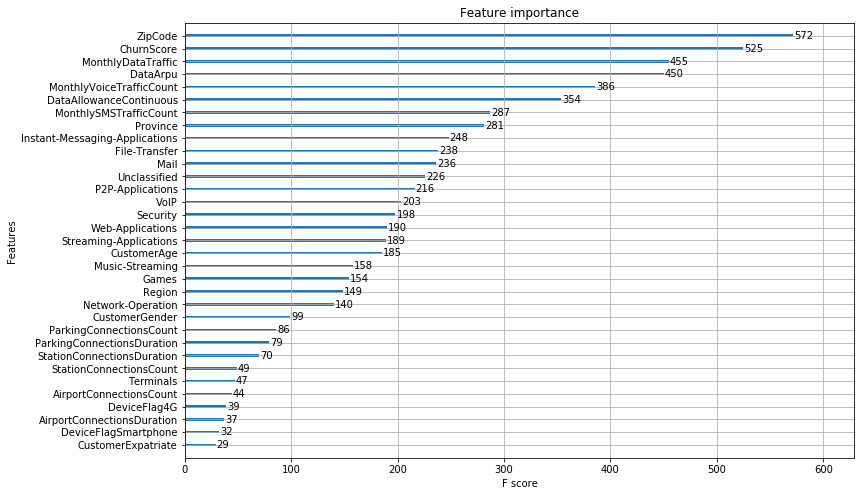

In [47]:
xgb3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=4,
        gamma=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.005,
        objective='multi:softprob', 
        num_class=4,
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb3, train, test, predictors)

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 60.64%


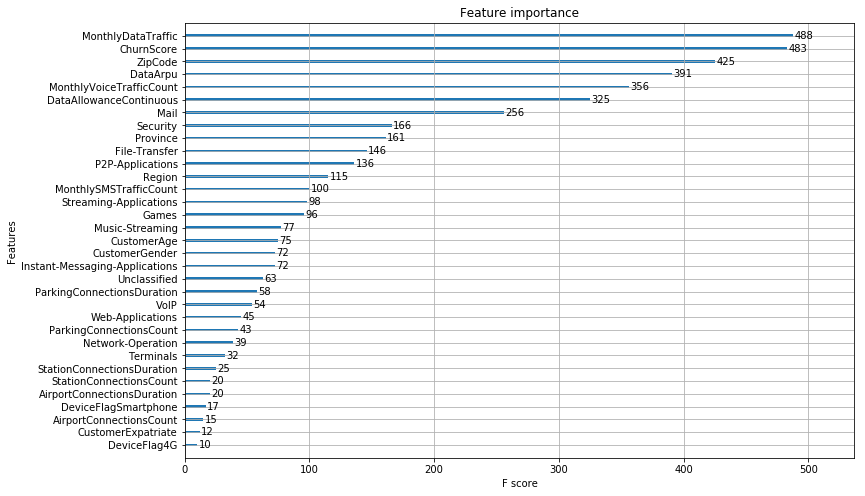

In [48]:
xgb4 = XGBClassifier(
        learning_rate =0.01,
        n_estimators=5000,
        max_depth=4,
        min_child_weight=4,
        gamma=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.005,
        objective='multi:softprob', 
        num_class=4,
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb4, train, test, predictors)

In [51]:
xtest = test.drop('predprob', 1)

Index(['ID', 'DeviceFlag4G', 'DataArpu', 'DataAllowanceContinuous',
       'DeviceFlagSmartphone', 'MonthlyVoiceTrafficCount',
       'MonthlySMSTrafficCount', 'MonthlyDataTraffic', 'CustomerGender',
       'CustomerExpatriate', 'ZipCode', 'ChurnScore',
       'AirportConnectionsDuration', 'AirportConnectionsCount',
       'StationConnectionsDuration', 'StationConnectionsCount',
       'ParkingConnectionsDuration', 'ParkingConnectionsCount',
       'File-Transfer', 'Games', 'Instant-Messaging-Applications', 'Mail',
       'Music-Streaming', 'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications', 'CustomerAge', 'Region', 'Province', 'predprob'],
      dtype='object')

In [60]:
train.columns

Index(['ID', 'DeviceFlag4G', 'DataArpu', 'DataAllowanceContinuous',
       'DeviceFlagSmartphone', 'MonthlyVoiceTrafficCount',
       'MonthlySMSTrafficCount', 'MonthlyDataTraffic', 'CustomerGender',
       'CustomerExpatriate', 'ZipCode', 'ChurnScore',
       'AirportConnectionsDuration', 'AirportConnectionsCount',
       'StationConnectionsDuration', 'StationConnectionsCount',
       'ParkingConnectionsDuration', 'ParkingConnectionsCount',
       'File-Transfer', 'Games', 'Instant-Messaging-Applications', 'Mail',
       'Music-Streaming', 'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications', 'CustomerAge', 'Region', 'Province', 'Product'],
      dtype='object')

In [67]:
train.columns

Index(['ID', 'DeviceFlag4G', 'DataArpu', 'DataAllowanceContinuous',
       'DeviceFlagSmartphone', 'MonthlyVoiceTrafficCount',
       'MonthlySMSTrafficCount', 'MonthlyDataTraffic', 'CustomerGender',
       'CustomerExpatriate', 'ZipCode', 'ChurnScore',
       'AirportConnectionsDuration', 'AirportConnectionsCount',
       'StationConnectionsDuration', 'StationConnectionsCount',
       'ParkingConnectionsDuration', 'ParkingConnectionsCount',
       'File-Transfer', 'Games', 'Instant-Messaging-Applications', 'Mail',
       'Music-Streaming', 'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications', 'CustomerAge', 'Region', 'Province', 'Product'],
      dtype='object')

In [70]:
predictors = [x for x in train.columns if x not in [target]]
xgb5 = XGBClassifier(
        learning_rate =0.01,
        n_estimators=5000,
        max_depth=4,
        min_child_weight=4,
        gamma=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.005,
        objective='multi:softprob', 
        num_class=4,
        nthread=4,
        scale_pos_weight=1,
        seed=27)

X_train, X_test, y_train, y_test = train_test_split(train[predictors], train[target], test_size=0.33, random_state=7)
eval_set = [(X_test, y_test)]
xgb5.fit(X_train,
      y_train,
      early_stopping_rounds=50,
      eval_metric="merror",
      eval_set=eval_set,
      verbose=False)

x_test = test.drop('predprob', 1)

y_pred_new_data = xgb5.predict(x_test)
predictions = [round(value) for value in y_pred_new_data]

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [72]:
from sklearn.metrics import f1_score
print("F1 score on unseen data: %.3f%%" % (f1_score(y_test, y_pred_new_data[0:3158], average='micro')*100))

F1 score on unseen data: 50.000%


In [95]:
y_pred_new_data
y = pd.DataFrame({'Product': y_pred_new_data})
y.shape

(3190, 1)

In [96]:
submit = test['ID']
submit = pd.DataFrame({'ID': submit})

pred = y
pred = pd.DataFrame({'Product': y_pred_new_data})

product = []
product = pred.Product
product.replace({ 
    int(0) : 'Non-Customer', 
    int(1) : 'V-Bag', 
    int(2) : 'V-Pet', 
    int(3) : 'V-Auto'},
    inplace=True)

submit = submit.join(product)
submit

,ID,Product
0,271,Non-Customer
1,6929,Non-Customer
2,7381,Non-Customer
3,4408,V-Auto
4,5440,Non-Customer
5,4190,Non-Customer
6,6524,Non-Customer
7,8562,Non-Customer
8,266,Non-Customer
9,12098,Non-Customer


In [99]:
submit.to_csv('result.csv', index = False, encoding='utf-8')